I tried a meta-learning method in this project. In this technique, first I used a pretrained ViT (Vision Transformer) model for the feature extraction stage, then applied PCA for the curse of dimensionality problem, and finally used a tuned SVC model for the classification stage.


### ViT Model (for Feature Extraction) -> PCA (for Dimensionality Reduction) -> SVC (for Classification)


|                                 | Training Feature Shape |
|---------------------------------|-------------|
| ViT Features                    | (974, 64)  |
| After PCA (98 % Variance Ratio) | (974, 41)   |


I have used the following methods.

* I tried to implementation of distributed deep learning strategy,
* I split the full data into train (974 images), validation (133 images) and test (60 images),
* I used a pretrained ViT model [1],
* Used <b>tf.data</b> for input pipeline,
* I used a SVM model for classification (tuned with optuna),


## My Another Projects
* [Flower Detect w/Meta Learning(ViT, CatBoost, SHAP)](https://www.kaggle.com/code/banddaniel/flower-detect-w-meta-learning-vit-catboost-shap)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)


## References
1. https://github.com/faustomorales/vit-keras

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from vit_keras import vit

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model

IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 1
AUTO = tf.data.AUTOTUNE

In [3]:
# Creatin mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


train_angular_leaf_spot = create_images_list('/kaggle/input/bean-leaf-lesions-classification/train/angular_leaf_spot')
train_bean_rust = create_images_list('/kaggle/input/bean-leaf-lesions-classification/train/bean_rust')
train_healthy = create_images_list('/kaggle/input/bean-leaf-lesions-classification/train/healthy')

val_angular_leaf_spot = create_images_list('/kaggle/input/bean-leaf-lesions-classification/val/angular_leaf_spot')
val_bean_rust = create_images_list('/kaggle/input/bean-leaf-lesions-classification/val/bean_rust')
val_healthy = create_images_list('/kaggle/input/bean-leaf-lesions-classification/val/healthy')


# look-up table
leaf_disease_classes = {0:'angular_leaf_spot', 1 : 'bean_rust', 2 : 'healthy'}

train_data = pd.concat([pd.DataFrame({'img': np.array(train_angular_leaf_spot)[20:], 'label':0 }),
                        pd.DataFrame({'img': np.array(train_bean_rust)[20:], 'label':1 }),
                        pd.DataFrame({'img': np.array(train_healthy)[20:], 'label':2 }) ], ignore_index = True)


val_data = pd.concat([pd.DataFrame({'img': np.array(val_angular_leaf_spot), 'label':0 }),
                      pd.DataFrame({'img': np.array(val_bean_rust), 'label':1 }),
                      pd.DataFrame({'img': np.array(val_healthy), 'label':2 }) ], ignore_index = True)

test_data = pd.concat([pd.DataFrame({'img': np.array(train_angular_leaf_spot)[:20], 'label':0 }),
                       pd.DataFrame({'img': np.array(train_bean_rust)[:20], 'label':1 }),
                       pd.DataFrame({'img': np.array(train_healthy)[:20], 'label':2 }) ], ignore_index = True)


train_data = shuffle(train_data, random_state = SEED).reset_index(drop = True)
val_data = shuffle(val_data, random_state = SEED).reset_index(drop = True)
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)

In [5]:
# There is a wrong file extend, find and delete

wrong_idx = 0
for i in range(train_data.shape[0]):
    if train_data['img'].values[i][-3:] == 'jpg':
        pass
    else:
        wrong_idx = i
        print('wrong file -> ',train_data['img'].values[i])
        
        
# Dropping wrong file
train_data.drop([wrong_idx], axis = 0, inplace = True)


print("train shape -> ", train_data.shape[0])
print("val shape -> ", val_data.shape[0])
print("test shape -> ", test_data.shape[0])

wrong file ->  /kaggle/input/bean-leaf-lesions-classification/train/healthy/healthy_train.120tore
train shape ->  974
val shape ->  133
test shape ->  60


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [6]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 6, seed = SEED)
    
    return img, label

In [7]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


# Training dataset without shuffling and data augmantation operations for the classification stage
train_loader_feature = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset_feature = (train_loader_feature
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((val_data['img'], val_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#3498db;"> Feature Extraction </span>

# <span style="color:#e74c3c;">Pretrained ViT Feature Extractor </span> Model

In [8]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16( image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 3)
    
    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(64, activation = 'gelu', name = 'the_feature_layer')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(3, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = "top_2_acc", dtype=None) ] )

347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 64)                49216     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                            

In [9]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, epochs = 5, batch_size = 16, validation_data = valid_dataset)
model.save("vit_feature_extractor.h5")

Epoch 1/5
31/31 [==============================] - 123s 927ms/step - loss: 0.6180 - acc: 0.7341 - top_2_acc: 0.9179 - val_loss: 0.5135 - val_acc: 0.6917 - val_top_2_acc: 1.0000
Epoch 2/5
31/31 [==============================] - 23s 720ms/step - loss: 0.2077 - acc: 0.9240 - top_2_acc: 0.9959 - val_loss: 0.5538 - val_acc: 0.7068 - val_top_2_acc: 0.9925
Epoch 3/5
31/31 [==============================] - 23s 725ms/step - loss: 0.1505 - acc: 0.9405 - top_2_acc: 0.9969 - val_loss: 0.5633 - val_acc: 0.7669 - val_top_2_acc: 0.9925
Epoch 4/5
31/31 [==============================] - 23s 730ms/step - loss: 0.0951 - acc: 0.9661 - top_2_acc: 1.0000 - val_loss: 0.5675 - val_acc: 0.8195 - val_top_2_acc: 1.0000
Epoch 5/5
31/31 [==============================] - 24s 737ms/step - loss: 0.1536 - acc: 0.9456 - top_2_acc: 0.9969 - val_loss: 0.3355 - val_acc: 0.8421 - val_top_2_acc: 1.0000


In [10]:
# Validation and Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    val_eval_vit = model.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
    print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
5/5 [==============================] - 1s 178ms/step - loss: 0.3355 - acc: 0.8421 - top_2_acc: 1.0000
Validation Loss: 0.335
Validation Accuracy: 84.211 %
----------------------------------------------------------------------------------------------------
2/2 [==============================] - 1s 230ms/step - loss: 0.4205 - acc: 0.8667 - top_2_acc: 1.0000
Test Loss: 0.420
Test Accuracy: 86.667 %


# <span style="color:#e74c3c;"> Classification </span> Stage

In [11]:
# Reading saved model and weights
feature_extr = tf.keras.models.load_model('/kaggle/working/vit_feature_extractor.h5')

# Feature extraction model 
feature_extractor_model = Model(inputs=feature_extr.input,
                                outputs=feature_extr.get_layer('the_feature_layer').output)

In [12]:
# Creating train features

with stg.scope():
    features = feature_extractor_model.predict(train_dataset_feature)

31/31 [==============================] - 14s 248ms/step


# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [13]:
# Applying PCA 41 components nearly equal to 0.98 variance ratio

pca_ = PCA(41)
pred_pca_ = pca_.fit(features)
pred_pca = pred_pca_.transform(features)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
train_features = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with a pretrained ViT feature extractor 
train_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,9.336931,1.291377,-0.028352,-0.114384,-0.156979,-0.730420,-0.030643,-0.934567,-0.229121,-0.400965,...,-0.200597,-0.424957,-0.140875,0.352021,-0.488063,-0.158364,-0.634384,0.144918,0.083200,0.413507
1,10.498340,2.142843,0.441578,-0.733656,-0.237601,0.338891,1.383833,-0.104146,0.159056,0.105001,...,-0.261831,0.006693,-0.238493,0.026807,-0.617644,0.347091,0.076496,-0.339898,0.166720,0.050411
2,-2.935587,-7.816936,-2.313654,-0.148232,-0.102279,0.105924,0.301064,-0.192691,0.294119,0.408426,...,0.079267,0.124696,0.031512,-0.199506,0.155225,-0.006811,0.000014,-0.082952,0.015667,-0.235886
3,-2.128824,7.276979,-2.420486,0.712861,0.648260,1.082198,-1.585273,-1.828291,0.690539,0.803827,...,0.487624,0.957231,0.494646,0.281749,-0.144309,-1.016826,-0.434732,-0.115213,-0.539796,-0.281482
4,-6.035010,5.719686,1.877144,0.266996,0.190890,-1.453024,-0.059801,-1.159038,0.908557,-0.911379,...,0.033638,0.003670,-0.088133,0.224913,0.405644,-0.555587,-0.161649,-0.146676,0.082694,0.024212


# <span style="color:#e74c3c;"> Classification SVM </span> Model

In [14]:
clf = SVC(kernel = 'rbf', random_state = SEED)

# Training SVM model with features from the ViT feature extractor
clf.fit(train_features,  train_data['label'])

SVC(random_state=1)

In [15]:
# Test set processing
# test feature exteaction -> applying PCA -> predictions of the LogisticRegression model

with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_features = pca_.transform(test_features)
test_features = pd.DataFrame(test_features, columns = new_feature_column_names)


test_pred = clf.predict(test_features)

2/2 [==============================] - 1s 218ms/step


# <span style="color:#e74c3c;"> Test  </span> Results

In [16]:
# Predictions and scores

mse = mean_squared_error(test_data['label'], test_pred)
f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
acc = accuracy_score(test_data['label'], test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

Mean Squared Error : 0.08333
Weighted F1 Score : 0.916
Accuracy Score : 91.667 %


# <span style="color:#e74c3c;"> Test Classification </span> Report


In [17]:
# classification report

clf_report = classification_report(test_data['label'], test_pred, target_names = list(leaf_disease_classes.values()))
print(clf_report)

                   precision    recall  f1-score   support

angular_leaf_spot       1.00      0.80      0.89        20
        bean_rust       0.83      0.95      0.88        20
          healthy       0.95      1.00      0.98        20

         accuracy                           0.92        60
        macro avg       0.93      0.92      0.92        60
     weighted avg       0.93      0.92      0.92        60



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

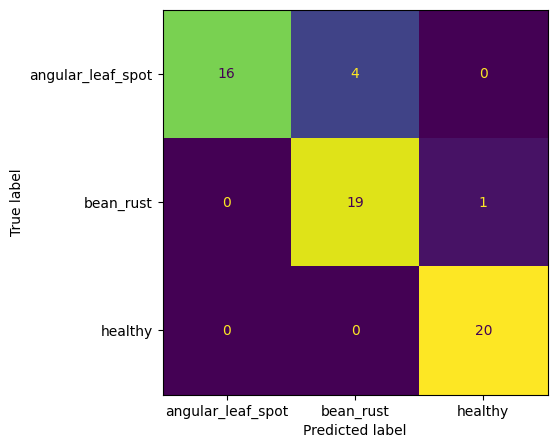

In [18]:
cm = confusion_matrix(test_data['label'], test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(leaf_disease_classes.values())) 

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax, colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [19]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + leaf_disease_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + leaf_disease_classes[label], fontsize = 8, color = 'red')

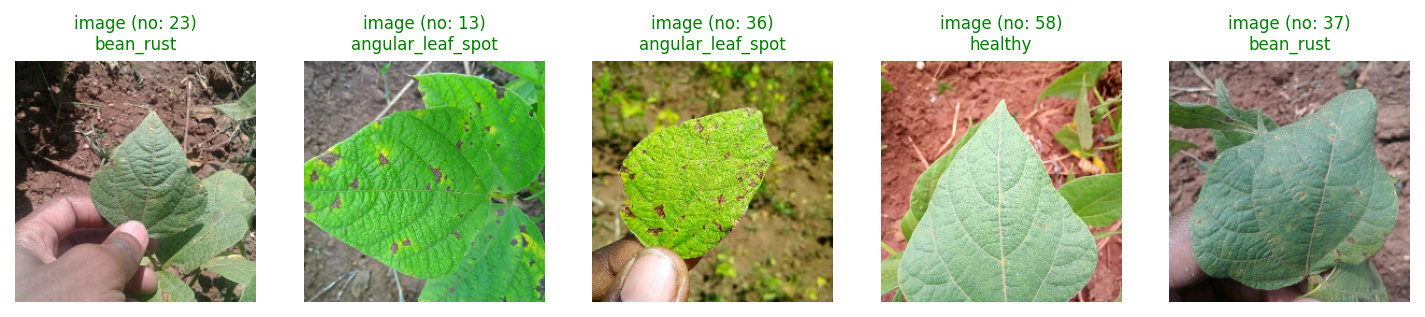

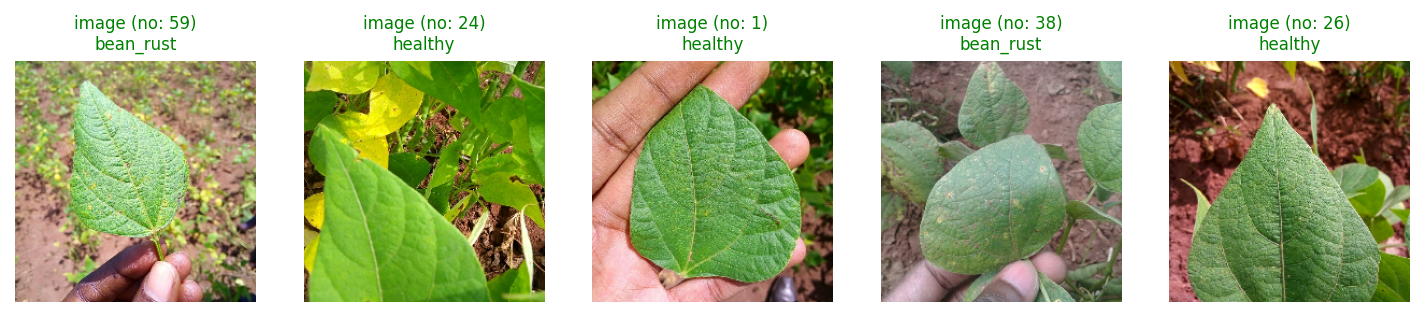

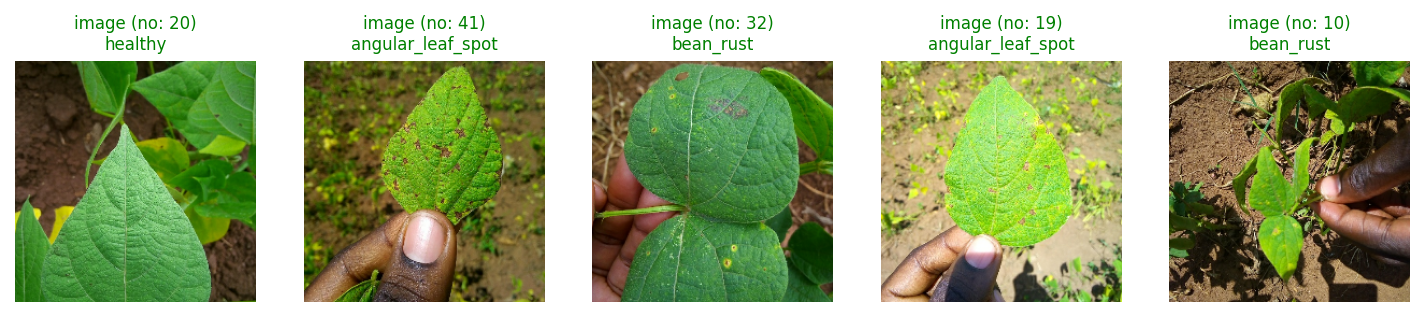

In [20]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 10)
random_test_sample_with_prediction(SEED = 43)
random_test_sample_with_prediction(SEED = 999)